# SBERT + HDBSCAN Visualization

This jupyter notebook generates publication-grade visualizations of clustering results from SBERT + HDBSCAN. Core features include generating a Comprehensive Analysis dashboard that integrates UMAP/t-SNE 2D manifold projections to visualize cluster distributions, plots long-tail distributions of cluster sizes alongside cumulative coverage curves, and intuitively displays key metrics such as silhouette scores and noise rates. The system further provides a multidimensional portrait of top clusters through a Quality Heatmap, quantifying clustering quality across three dimensions: internal coherence, separation, and density.

In [ ]:

import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import font_manager
from pathlib import Path
from collections import Counter
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings("ignore")


import seaborn as sns
import pandas as pd
HAS_PANDAS = True



try:
    REPO_ROOT = Path(__file__).resolve().parents[2]
except NameError:
    # Jupyter Notebook fallback
    curr = Path('.').resolve()
    if (curr / 'data').exists():
        REPO_ROOT = curr
    elif (curr.parent / 'data').exists():
        REPO_ROOT = curr.parent
    elif (curr.parents[1] / 'data').exists():
        REPO_ROOT = curr.parents[1]
    else:
        REPO_ROOT = curr # Fallback
OUT_DIR = REPO_ROOT / "data" / "sbert_hdbscan_test"
VIZ_OUT_DIR = OUT_DIR / "visualizations" / "paper_quality"
VIZ_OUT_DIR.mkdir(parents=True, exist_ok=True)


EMBEDDINGS_PATH = OUT_DIR / "sbert_embeddings_norm.npy"
CLUSTER_LABELS_PATH = OUT_DIR / "hdbscan_labels.npy"
DOC_IDS_PATH = OUT_DIR / "doc_ids.npy"
DOC_TITLES_PATH = OUT_DIR / "doc_titles.npy"
CLUSTER_TOP_TERMS_PATH = OUT_DIR / "cluster_top_terms.json"
METRICS_PATH = OUT_DIR / "hdbscan_metrics.json"

plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'mathtext.fontset': 'stix',
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'text.usetex': False, 
})


COLORS = {
    'primary': '#2c3e50',      
    'secondary': '#3498db',    
    'accent': '#e74c3c',       
    'success': '#27ae60',      
    'warning': '#f39c12',      
    'info': '#3498db',         
    'cluster_palette': 'tab20', 
}

sns.set_style("whitegrid", {
    'axes.linewidth': 1.2,
    'grid.linewidth': 0.8,
    'grid.alpha': 0.3,
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
})


def load_data():
    print("[i] Loading data...")
    embeddings = np.load(EMBEDDINGS_PATH)
    labels = np.load(CLUSTER_LABELS_PATH)
    doc_ids = np.load(DOC_IDS_PATH)
    doc_titles = np.load(DOC_TITLES_PATH)
    
    with METRICS_PATH.open("r", encoding="utf-8") as f:
        metrics = json.load(f)
    
    with CLUSTER_TOP_TERMS_PATH.open("r", encoding="utf-8") as f:
        cluster_top_terms = json.load(f)
    
    # Handle dimension mismatch (e.g. if using full embeddings for subset labels)
    if len(embeddings) != len(labels):
        print(f"[warn] Dimension mismatch: embeddings {len(embeddings)} vs labels {len(labels)}")
        if len(embeddings) > len(labels):
            print(f"[warn] Slicing embeddings to match labels (taking first {len(labels)})")
            embeddings = embeddings[:len(labels)]
        else:
            raise ValueError(f"Embeddings ({len(embeddings)}) fewer than labels ({len(labels)})")

    print(f"[i] Loaded {len(labels)} documents, {len(embeddings)} embeddings")
    print(f"[i] Number of clusters: {metrics['k']}")
    print(f"[i] Noise rate: {metrics['noise_rate']:.2%}")
    
    return embeddings, labels, doc_ids, doc_titles, metrics, cluster_top_terms


def calculate_cluster_statistics(embeddings: np.ndarray, labels: np.ndarray) -> Dict:
    clustered_mask = labels != -1
    X_clustered = embeddings[clustered_mask]
    labels_clustered = labels[clustered_mask]
    
    unique_labels = np.unique(labels_clustered)
    stats = {
        'cluster_internal_coherence': {},
        'cluster_separation': {},
        'cluster_density': {},
        'cluster_compactness': {},
    }
    
    from sklearn.metrics.pairwise import euclidean_distances
    
    for label in unique_labels:
        mask = labels_clustered == label
        cluster_points = X_clustered[mask]
        centroid = cluster_points.mean(axis=0)
        
        distances_to_centroid = np.linalg.norm(cluster_points - centroid, axis=1)
        stats['cluster_internal_coherence'][label] = float(distances_to_centroid.mean())
        
        if len(cluster_points) > 1:
            pairwise_distances = euclidean_distances(cluster_points)
            stats['cluster_density'][label] = float(len(cluster_points) / (pairwise_distances.max() + 1e-10))
        else:
            stats['cluster_density'][label] = 0.0
        
        stats['cluster_compactness'][label] = float(distances_to_centroid.std())
    
    centroids = {}
    for label in unique_labels:
        mask = labels_clustered == label
        centroids[label] = X_clustered[mask].mean(axis=0)
    
    centroid_array = np.array([centroids[label] for label in unique_labels])
    inter_cluster_distances = euclidean_distances(centroid_array)
    np.fill_diagonal(inter_cluster_distances, np.inf)
    
    for i, label in enumerate(unique_labels):
        stats['cluster_separation'][label] = float(inter_cluster_distances[i].min())
    
    return stats


def sample_clustered_embeddings(embeddings: np.ndarray,
                                labels: np.ndarray,
                                sample_size: int = 20000) -> Tuple[np.ndarray, np.ndarray]:
    """Return a representative subset of clustered points (excludes noise)."""
    clustered_mask = labels != -1
    X_clustered = embeddings[clustered_mask]
    labels_clustered = labels[clustered_mask]

    if len(labels_clustered) == 0:
        return np.empty((0, embeddings.shape[1])), labels_clustered

    if len(labels_clustered) > sample_size:
        indices = np.random.choice(len(labels_clustered), size=sample_size, replace=False)
        X_clustered = X_clustered[indices]
        labels_clustered = labels_clustered[indices]

    return X_clustered, labels_clustered


def compute_davies_bouldin_from_sample(X_sample: np.ndarray,
                                       y_sample: np.ndarray) -> Optional[float]:
    """Compute Davies-Bouldin on a prepared sample."""
    if len(y_sample) == 0 or len(np.unique(y_sample)) < 2:
        return None

    from sklearn.metrics import davies_bouldin_score

    try:
        score = davies_bouldin_score(X_sample, y_sample)
    except Exception as exc:
        print(f"[warn] Failed to compute Davies-Bouldin score: {exc}")
        return None

    return float(score)








In [11]:
print("=" * 70)
print("Paper-Quality Clustering Visualization")
print("=" * 70)

embeddings, labels, doc_ids, doc_titles, metrics, cluster_top_terms = load_data()

metrics_lsa = None
metrics_lsa_path = REPO_ROOT / "data" / "metrics" / "kmeans_lsa_metrics.json"
if metrics_lsa_path.exists():
    with metrics_lsa_path.open("r", encoding="utf-8") as f:
        metrics_lsa = json.load(f)
else:
    print(f"[warn] LSA metrics not found at {metrics_lsa_path}")



Paper-Quality Clustering Visualization
[i] Loading data...
[warn] Dimension mismatch: embeddings 732366 vs labels 73236
[warn] Slicing embeddings to match labels (taking first 73236)
[i] Loaded 73236 documents, 73236 embeddings
[i] Number of clusters: 257
[i] Noise rate: 48.52%



[1] Creating comprehensive clustering analysis...
[i] Creating comprehensive clustering analysis figure...
[i] Saved: /work3/s242644/ds/PaperTrail/data/sbert_hdbscan_7w/visualizations/paper_quality/comprehensive_clustering_analysis.png


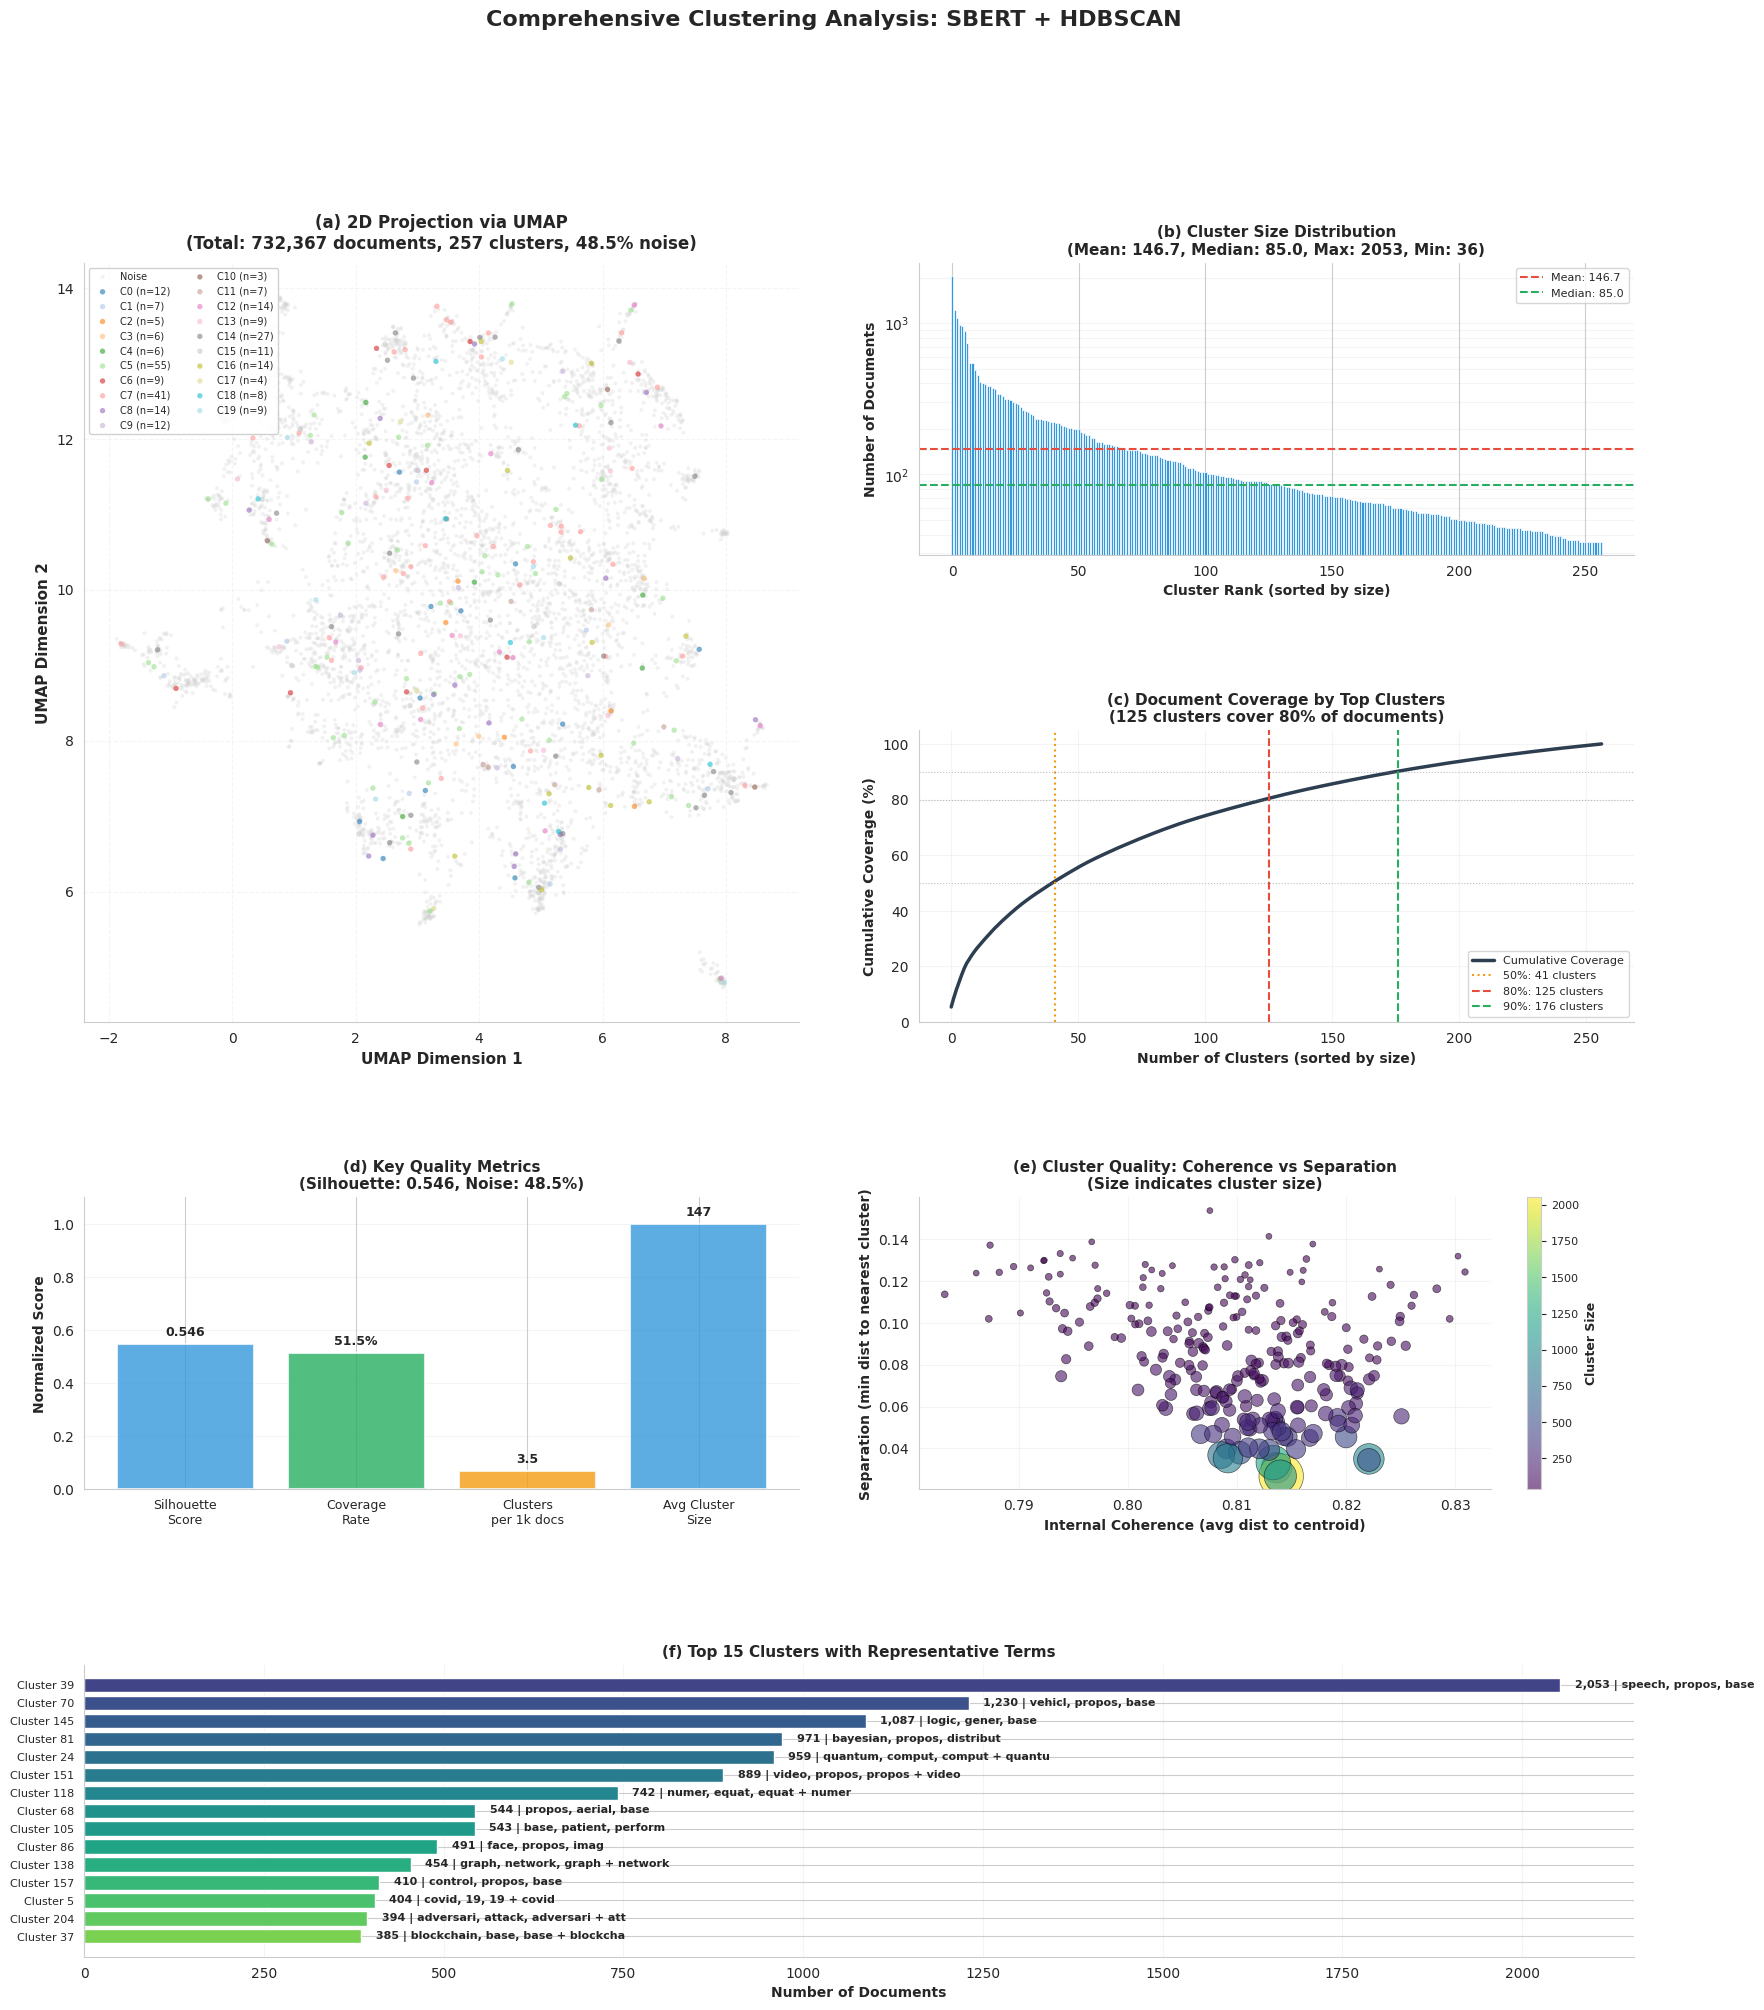

In [26]:
print("\n[1] Creating comprehensive clustering analysis...")

def plot_comprehensive_clustering_analysis(embeddings: np.ndarray, labels: np.ndarray, 
                                         metrics: Dict, cluster_top_terms: Dict):
    print("[i] Creating comprehensive clustering analysis figure...")
    
    cluster_stats = calculate_cluster_statistics(embeddings, labels)
    
    sample_size = min(10000, len(embeddings))
    if len(embeddings) > sample_size:
        indices = np.random.choice(len(embeddings), size=sample_size, replace=False)
        X_sample = embeddings[indices]
        labels_sample = labels[indices]
    else:
        X_sample = embeddings
        labels_sample = labels
    
    try:
        import umap
        reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
        X_2d = reducer.fit_transform(X_sample)
        method_name = "UMAP"
    except ImportError:
        from sklearn.manifold import TSNE
        X_2d = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X_sample)
        method_name = "t-SNE"
    
    fig = plt.figure(figsize=(20, 22))
    gs = fig.add_gridspec(4, 4, hspace=0.6, wspace=0.4)
    
    ax1 = fig.add_subplot(gs[0:2, 0:2])
    noise_mask = labels_sample == -1
    clustered_mask = ~noise_mask
    unique_labels = np.unique(labels_sample[clustered_mask])
    
    if noise_mask.sum() > 0:
        ax1.scatter(X_2d[noise_mask, 0], X_2d[noise_mask, 1], 
                   c='lightgray', s=8, alpha=0.3, label='Noise', 
                   rasterized=True, edgecolors='none')
    
    if len(unique_labels) > 0:
        colors = plt.cm.tab20(np.linspace(0, 1, min(len(unique_labels), 20)))
        for i, label in enumerate(unique_labels[:20]):
            mask = labels_sample == label
            size = mask.sum()
            ax1.scatter(X_2d[mask, 0], X_2d[mask, 1], 
                       c=[colors[i]], s=15, alpha=0.6, 
                       label=f'C{label} (n={size})' if size < 1000 else f'C{label}',
                       rasterized=True, edgecolors='none')
    
    ax1.set_xlabel(f'{method_name} Dimension 1', fontsize=11, fontweight='bold')
    ax1.set_ylabel(f'{method_name} Dimension 2', fontsize=11, fontweight='bold')
    ax1.set_title(f'(a) 2D Projection via {method_name}\n'
                  f'(Total: 732,367 documents, '
                  f'{metrics["k"]} clusters, '
                  f'{metrics["noise_rate"]:.1%} noise)', 
                  fontsize=12, fontweight='bold', pad=10)
    ax1.legend(loc='upper left', fontsize=7, framealpha=0.9, ncol=2)
    ax1.grid(True, alpha=0.2, linestyle='--')
    
    ax2 = fig.add_subplot(gs[0, 2:4])
    unique_labels_all, counts_all = np.unique(labels[labels != -1], return_counts=True)
    sorted_counts = sorted(counts_all, reverse=True)
    
    bars = ax2.bar(range(len(sorted_counts)), sorted_counts, 
                   color=COLORS['secondary'], edgecolor='white', linewidth=0.5)
    
    mean_size = np.mean(sorted_counts)
    median_size = np.median(sorted_counts)
    ax2.axhline(y=mean_size, color=COLORS['accent'], linestyle='--', 
                linewidth=1.5, label=f'Mean: {mean_size:.1f}')
    ax2.axhline(y=median_size, color=COLORS['success'], linestyle='--', 
                linewidth=1.5, label=f'Median: {median_size:.1f}')
    
    ax2.set_xlabel('Cluster Rank (sorted by size)', fontsize=10, fontweight='bold')
    ax2.set_ylabel('Number of Documents', fontsize=10, fontweight='bold')
    ax2.set_title(f'(b) Cluster Size Distribution\n'
                  f'(Mean: {mean_size:.1f}, Median: {median_size:.1f}, '
                  f'Max: {max(sorted_counts)}, Min: {min(sorted_counts)})', 
                  fontsize=11, fontweight='bold')
    ax2.set_yscale('log')
    ax2.legend(fontsize=8, loc='upper right')
    ax2.grid(True, alpha=0.2, axis='y', which='both')
    
    ax3 = fig.add_subplot(gs[1, 2:4])
    cumulative_coverage = np.cumsum(sorted_counts) / sum(sorted_counts)
    
    coverage_50_idx = np.where(cumulative_coverage >= 0.5)[0]
    coverage_80_idx = np.where(cumulative_coverage >= 0.8)[0]
    coverage_90_idx = np.where(cumulative_coverage >= 0.9)[0]
    
    coverage_50_num = coverage_50_idx[0] + 1 if len(coverage_50_idx) > 0 else len(cumulative_coverage)
    coverage_80_num = coverage_80_idx[0] + 1 if len(coverage_80_idx) > 0 else len(cumulative_coverage)
    coverage_90_num = coverage_90_idx[0] + 1 if len(coverage_90_idx) > 0 else len(cumulative_coverage)
    
    ax3.plot(range(len(cumulative_coverage)), cumulative_coverage * 100, 
            linewidth=2.5, color=COLORS['primary'], label='Cumulative Coverage')
    
    ax3.axvline(x=coverage_50_num, color=COLORS['warning'], linestyle=':', 
               linewidth=1.5, label=f'50%: {coverage_50_num} clusters')
    ax3.axvline(x=coverage_80_num, color=COLORS['accent'], linestyle='--', 
               linewidth=1.5, label=f'80%: {coverage_80_num} clusters')
    ax3.axvline(x=coverage_90_num, color=COLORS['success'], linestyle='--', 
               linewidth=1.5, label=f'90%: {coverage_90_num} clusters')
    
    for pct in [50, 80, 90]:
        ax3.axhline(y=pct, color='gray', linestyle=':', linewidth=0.8, alpha=0.5)
    
    ax3.set_xlabel('Number of Clusters (sorted by size)', fontsize=10, fontweight='bold')
    ax3.set_ylabel('Cumulative Coverage (%)', fontsize=10, fontweight='bold')
    ax3.set_title(f'(c) Document Coverage by Top Clusters\n'
                  f'({coverage_80_num} clusters cover 80% of documents)', 
                  fontsize=11, fontweight='bold')
    ax3.set_ylim([0, 105])
    ax3.legend(fontsize=8, loc='lower right')
    ax3.grid(True, alpha=0.2)
    
    ax4 = fig.add_subplot(gs[2, 0:2])
    
    metrics_to_plot = {
        'Silhouette\nScore': metrics.get('silhouette', 0),
        'Coverage\nRate': metrics.get('coverage', 0),
        'Clusters\nper 1k docs': metrics['k'] / (metrics['n'] / 1000),
        'Avg Cluster\nSize': metrics['clustered'] / metrics['k'] if metrics['k'] > 0 else 0,
    }
    
    normalized_values = {
        'Silhouette\nScore': metrics_to_plot['Silhouette\nScore'],
        'Coverage\nRate': metrics_to_plot['Coverage\nRate'],
        'Clusters\nper 1k docs': min(metrics_to_plot['Clusters\nper 1k docs'] / 50, 1.0),
        'Avg Cluster\nSize': min(metrics_to_plot['Avg Cluster\nSize'] / 100, 1.0),
    }
    
    x_pos = np.arange(len(metrics_to_plot))
    bars = ax4.bar(x_pos, list(normalized_values.values()), 
                   color=[COLORS['secondary'], COLORS['success'], 
                         COLORS['warning'], COLORS['info']],
                   edgecolor='white', linewidth=1.5, alpha=0.8)
    
    for i, (bar, (key, val)) in enumerate(zip(bars, metrics_to_plot.items())):
        height = bar.get_height()
        if key == 'Silhouette\nScore':
            label_text = f'{val:.3f}'
        elif key == 'Coverage\nRate':
            label_text = f'{val:.1%}'
        elif key == 'Clusters\nper 1k docs':
            label_text = f'{val:.1f}'
        else:
            label_text = f'{val:.0f}'
        
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                label_text, ha='center', va='bottom', 
                fontsize=9, fontweight='bold')
    
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(list(metrics_to_plot.keys()), fontsize=9)
    ax4.set_ylabel('Normalized Score', fontsize=10, fontweight='bold')
    ax4.set_title(f'(d) Key Quality Metrics\n'
                  f'(Silhouette: {metrics.get("silhouette", 0):.3f}, '
                  f'Noise: {metrics["noise_rate"]:.1%})', 
                  fontsize=11, fontweight='bold')
    ax4.set_ylim([0, 1.1])
    ax4.grid(True, alpha=0.2, axis='y')
    
    ax5 = fig.add_subplot(gs[2, 2:4])
    
    coherence_values = []
    separation_values = []
    cluster_sizes = []
    
    for label in unique_labels_all:
        if label in cluster_stats['cluster_internal_coherence']:
            coherence_values.append(cluster_stats['cluster_internal_coherence'][label])
            separation_values.append(cluster_stats['cluster_separation'][label])
            cluster_sizes.append(counts_all[unique_labels_all == label][0])
    
    scatter = ax5.scatter(coherence_values, separation_values, 
                         s=[s*0.5 for s in cluster_sizes], 
                         c=cluster_sizes, cmap='viridis', 
                         alpha=0.6, edgecolors='black', linewidth=0.5)
    
    ax5.set_xlabel('Internal Coherence (avg dist to centroid)', 
                   fontsize=10, fontweight='bold')
    ax5.set_ylabel('Separation (min dist to nearest cluster)', 
                   fontsize=10, fontweight='bold')
    ax5.set_title('(e) Cluster Quality: Coherence vs Separation\n'
                  '(Size indicates cluster size)', 
                  fontsize=11, fontweight='bold')
    
    cbar = plt.colorbar(scatter, ax=ax5)
    cbar.set_label('Cluster Size', fontsize=9, fontweight='bold')
    cbar.ax.tick_params(labelsize=8)
    
    ax5.grid(True, alpha=0.2)
    
    ax6 = fig.add_subplot(gs[3, 0:4])
    
    label_to_count = dict(zip(unique_labels_all, counts_all))
    sorted_clusters = sorted(label_to_count.items(), key=lambda x: x[1], reverse=True)[:15]
    
    cluster_ids = [str(cid) for cid, _ in sorted_clusters]
    cluster_sizes_plot = [size for _, size in sorted_clusters]
    
    top_terms_display = []
    for cid in cluster_ids:
        if cid in cluster_top_terms:
            terms = cluster_top_terms[cid][:3]  # 取前3个主题词
            top_terms_display.append(', '.join([t[:15] for t in terms]))
        else:
            top_terms_display.append("No terms")
    
    y_pos = np.arange(len(cluster_ids))
    bars = ax6.barh(y_pos, cluster_sizes_plot, 
                    color=plt.cm.viridis(np.linspace(0.2, 0.8, len(cluster_ids))),
                    edgecolor='white', linewidth=1)
    
    for i, (bar, size, terms) in enumerate(zip(bars, cluster_sizes_plot, top_terms_display)):
        ax6.text(size + max(cluster_sizes_plot)*0.01, bar.get_y() + bar.get_height()/2,
                f'{size:,} | {terms}', 
                va='center', fontsize=8, fontweight='bold')
    
    ax6.set_yticks(y_pos)
    ax6.set_yticklabels([f'Cluster {cid}' for cid in cluster_ids], fontsize=8)
    ax6.set_xlabel('Number of Documents', fontsize=10, fontweight='bold')
    ax6.set_title('(f) Top 15 Clusters with Representative Terms', 
                  fontsize=11, fontweight='bold')
    ax6.invert_yaxis()
    ax6.grid(True, alpha=0.2, axis='x')
    
    fig.suptitle('Comprehensive Clustering Analysis: SBERT + HDBSCAN', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.savefig(VIZ_OUT_DIR / "comprehensive_clustering_analysis.png", 
                dpi=300, bbox_inches='tight', facecolor='white')
    print(f"[i] Saved: {VIZ_OUT_DIR / 'comprehensive_clustering_analysis.png'}")
    plt.show()

plot_comprehensive_clustering_analysis(embeddings, labels, metrics, cluster_top_terms)




[3] Creating Davies-Bouldin comparisons...
[i] Creating Davies-Bouldin comparisons...
[i] Loading LSA data for subset analysis...
[i] Saved: /work3/s242644/ds/PaperTrail/data/sbert_hdbscan_test/visualizations/paper_quality/davies_bouldin_comparisons.png


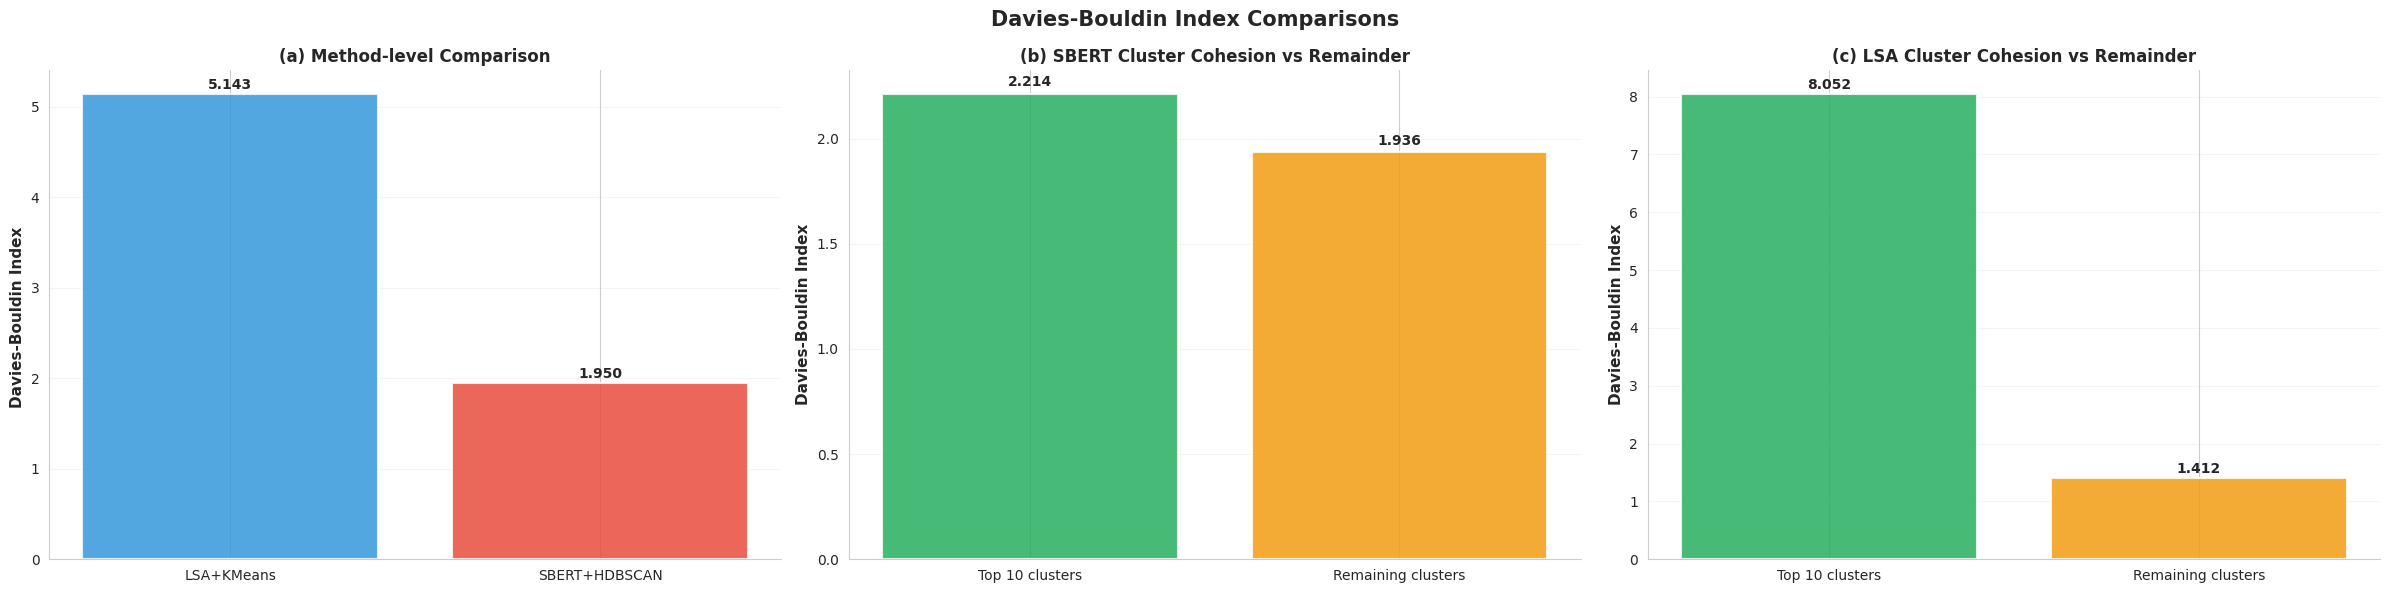

In [ ]:
print("\n[3] Creating Davies-Bouldin comparisons...")

def plot_davies_bouldin_comparisons(embeddings: np.ndarray,
                                    labels: np.ndarray,
                                    metrics_lsa: Optional[Dict],
                                    top_n_clusters: int = 10):
    print("[i] Creating Davies-Bouldin comparisons...")

    # --- SBERT Data ---
    X_sample, y_sample = sample_clustered_embeddings(embeddings, labels, sample_size=20000)
    db_sbert = compute_davies_bouldin_from_sample(X_sample, y_sample)

    # --- LSA Data ---
    db_lsa = None
    if metrics_lsa:
        if metrics_lsa.get('DBI') is not None:
            db_lsa = metrics_lsa.get('DBI')
        elif metrics_lsa.get('davies_bouldin') is not None:
            db_lsa = metrics_lsa.get('davies_bouldin')

    lsa_path = REPO_ROOT / "data" / "lsa" / "lsa_reduced.npz"
    lsa_labels_path = REPO_ROOT / "data" / "lsa" / "cluster_labels.npy"
    
    has_lsa_data = False
    lsa_db_top = None
    lsa_db_rest = None
    top_labels_lsa = []
    
    if lsa_path.exists() and lsa_labels_path.exists():
        try:
            print("[i] Loading LSA data for subset analysis...")
            with np.load(lsa_path) as data:
                X_lsa = data['X_reduced']
            y_lsa = np.load(lsa_labels_path)
            
            # Sample LSA
            X_lsa_sample, y_lsa_sample = sample_clustered_embeddings(X_lsa, y_lsa, sample_size=20000)
            
            # If DB not in metrics, compute from sample
            if db_lsa is None:
                 db_lsa = compute_davies_bouldin_from_sample(X_lsa_sample, y_lsa_sample)
            
            # Compute Top/Rest for LSA
            if len(y_lsa_sample) > 0 and len(np.unique(y_lsa_sample)) > 1:
                label_counts_lsa = Counter(y_lsa[y_lsa != -1])
                top_labels_lsa = [label for label, _ in label_counts_lsa.most_common(top_n_clusters)]
                top_mask_lsa = np.isin(y_lsa_sample, top_labels_lsa)
                rest_mask_lsa = ~top_mask_lsa
                
                if top_mask_lsa.sum() > 0:
                    lsa_db_top = compute_davies_bouldin_from_sample(X_lsa_sample[top_mask_lsa], y_lsa_sample[top_mask_lsa])
                if rest_mask_lsa.sum() > 0:
                    lsa_db_rest = compute_davies_bouldin_from_sample(X_lsa_sample[rest_mask_lsa], y_lsa_sample[rest_mask_lsa])
            
            has_lsa_data = True
        except Exception as e:
            print(f"[warn] Failed to load/process LSA data: {e}")

    if db_sbert is None and db_lsa is None:
        print("[warn] Davies-Bouldin scores unavailable, skipping comparison")
        return

    # --- Plotting ---
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    fig.suptitle('Davies-Bouldin Index Comparisons', fontsize=15, fontweight='bold', y=0.98)

    # (a) Method-level Comparison
    ax1 = axes[0]
    method_names = []
    method_scores = []
    method_colors = []
    if db_lsa is not None:
        method_names.append('LSA+KMeans')
        method_scores.append(db_lsa)
        method_colors.append(COLORS['secondary'])
    if db_sbert is not None:
        method_names.append('SBERT+HDBSCAN')
        method_scores.append(db_sbert)
        method_colors.append(COLORS['accent'])

    if method_scores:
        bars = ax1.bar(method_names, method_scores,
                       color=method_colors, edgecolor='white', linewidth=1.5, alpha=0.85)
        for bar, val in zip(bars, method_scores):
            ax1.text(bar.get_x() + bar.get_width() / 2., val + 0.02,
                     f'{val:.3f}', ha='center', va='bottom',
                     fontsize=10, fontweight='bold')
        ax1.set_ylabel('Davies-Bouldin Index ', fontsize=11, fontweight='bold')
        ax1.set_title('(a) Method-level Comparison', fontsize=12, fontweight='bold')
        ax1.grid(True, alpha=0.2, axis='y')
    else:
        ax1.axis('off')
        ax1.text(0.5, 0.5, 'No Davies-Bouldin metrics available',
                 ha='center', va='center', fontsize=11, fontweight='bold')

    # (b) SBERT Top vs Rest
    ax2 = axes[1]
    if len(y_sample) > 0 and len(np.unique(y_sample)) > 1:
        label_counts = Counter(labels[labels != -1])
        top_labels = [label for label, _ in label_counts.most_common(top_n_clusters)]
        top_mask = np.isin(y_sample, top_labels)
        rest_mask = ~top_mask

        db_top = compute_davies_bouldin_from_sample(X_sample[top_mask], y_sample[top_mask]) if top_mask.sum() > 0 else None
        db_rest = compute_davies_bouldin_from_sample(X_sample[rest_mask], y_sample[rest_mask]) if rest_mask.sum() > 0 else None

        subset_names = []
        subset_scores = []
        subset_colors = []
        if db_top is not None:
            subset_names.append(f'Top {min(top_n_clusters, len(top_labels))} clusters')
            subset_scores.append(db_top)
            subset_colors.append(COLORS['success'])
        if db_rest is not None:
            subset_names.append('Remaining clusters')
            subset_scores.append(db_rest)
            subset_colors.append(COLORS['warning'])

        if subset_scores:
            bars = ax2.bar(subset_names, subset_scores,
                           color=subset_colors, edgecolor='white', linewidth=1.5, alpha=0.85)
            for bar, val in zip(bars, subset_scores):
                ax2.text(bar.get_x() + bar.get_width() / 2., val + 0.02,
                         f'{val:.3f}', ha='center', va='bottom',
                         fontsize=10, fontweight='bold')
            ax2.set_ylabel('Davies-Bouldin Index', fontsize=11, fontweight='bold')
            ax2.set_title('(b) SBERT Cluster Cohesion vs Remainder', fontsize=12, fontweight='bold')
            ax2.grid(True, alpha=0.2, axis='y')
        else:
            ax2.axis('off')
            ax2.text(0.5, 0.5, 'Not enough clusters for subset comparison',
                     ha='center', va='center', fontsize=11, fontweight='bold')
    else:
        ax2.axis('off')
        ax2.text(0.5, 0.5, 'Not enough clustered samples for comparison',
                 ha='center', va='center', fontsize=11, fontweight='bold')

    # (c) LSA Top vs Rest
    ax3 = axes[2]
    if has_lsa_data and (lsa_db_top is not None or lsa_db_rest is not None):
        subset_names = []
        subset_scores = []
        subset_colors = []
        if lsa_db_top is not None:
            subset_names.append(f'Top {min(top_n_clusters, len(top_labels_lsa))} clusters')
            subset_scores.append(lsa_db_top)
            subset_colors.append(COLORS['success'])
        if lsa_db_rest is not None:
            subset_names.append('Remaining clusters')
            subset_scores.append(lsa_db_rest)
            subset_colors.append(COLORS['warning'])
        
        if subset_scores:
            bars = ax3.bar(subset_names, subset_scores,
                           color=subset_colors, edgecolor='white', linewidth=1.5, alpha=0.85)
            for bar, val in zip(bars, subset_scores):
                ax3.text(bar.get_x() + bar.get_width() / 2., val + 0.02,
                         f'{val:.3f}', ha='center', va='bottom',
                         fontsize=10, fontweight='bold')
            ax3.set_ylabel('Davies-Bouldin Index', fontsize=11, fontweight='bold')
            ax3.set_title('(c) LSA Cluster Cohesion vs Remainder', fontsize=12, fontweight='bold')
            ax3.grid(True, alpha=0.2, axis='y')
        else:
            ax3.axis('off')
            ax3.text(0.5, 0.5, 'Not enough data for subset comparison',
                     ha='center', va='center', fontsize=11, fontweight='bold')
    else:
        ax3.axis('off')
        ax3.text(0.5, 0.5, 'LSA data not available\nfor subset analysis',
                 ha='center', va='center', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.savefig(VIZ_OUT_DIR / "davies_bouldin_comparisons.png",
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

plot_davies_bouldin_comparisons(embeddings, labels, metrics_lsa)





[4] Creating cluster quality heatmap...
[i] Creating cluster quality heatmap...
[i] Saved: /work3/s242644/ds/PaperTrail/data/sbert_hdbscan_7w/visualizations/paper_quality/cluster_quality_heatmap.png


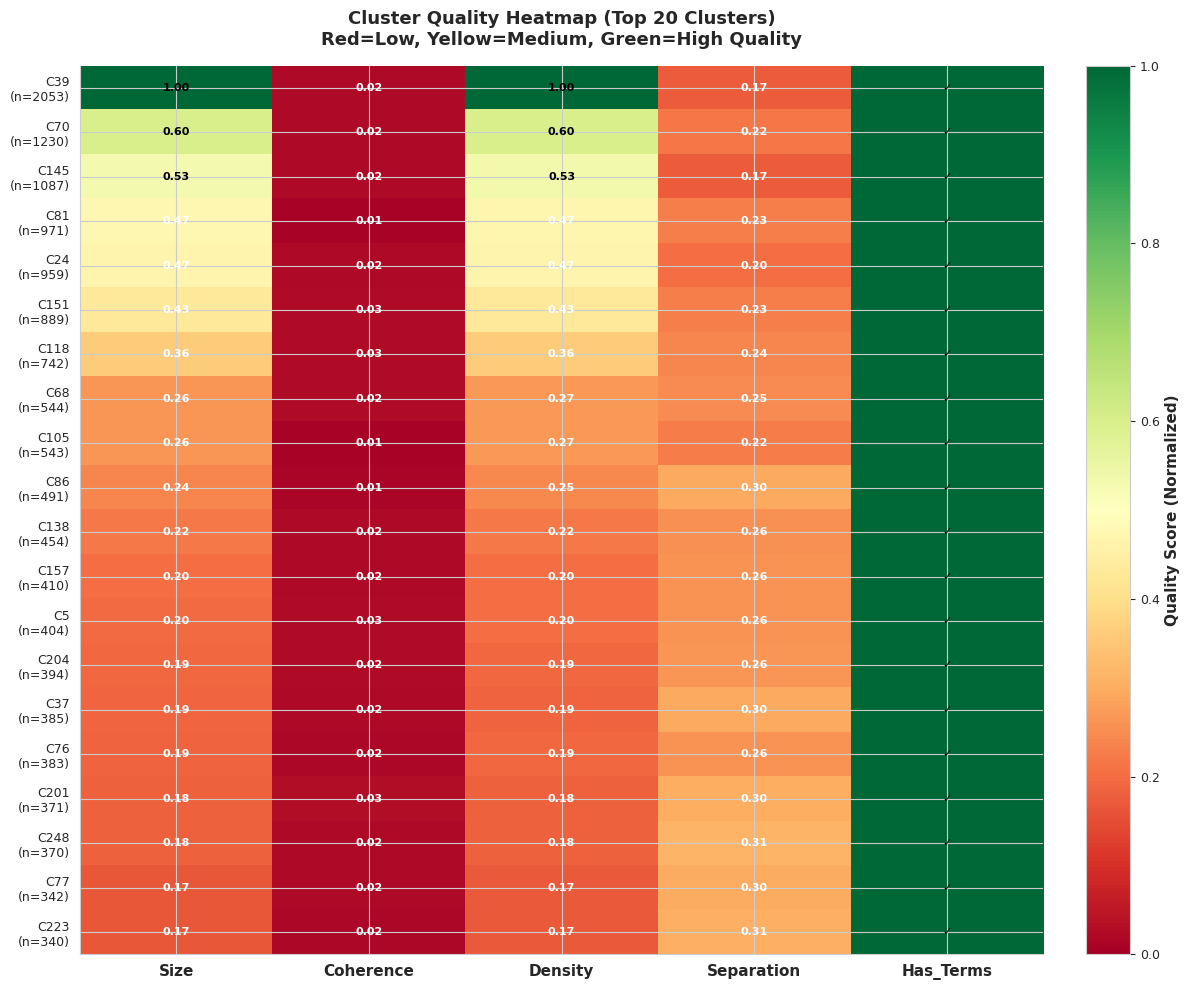

In [6]:
print("\n[4] Creating cluster quality heatmap...")

def plot_cluster_quality_heatmap(embeddings: np.ndarray, labels: np.ndarray, 
                                 cluster_top_terms: Dict, top_n: int = 20):
    print("[i] Creating cluster quality heatmap...")
    
    clustered_mask = labels != -1
    X_clustered = embeddings[clustered_mask]
    labels_clustered = labels[clustered_mask]
    
    unique_labels, counts = np.unique(labels_clustered, return_counts=True)
    label_to_count = dict(zip(unique_labels, counts))
    
    sorted_clusters = sorted(label_to_count.items(), key=lambda x: x[1], reverse=True)[:top_n]
    selected_labels = [label for label, _ in sorted_clusters]
    
    quality_matrix = []
    metric_names = ['Size', 'Coherence', 'Density', 'Separation', 'Has_Terms']
    cluster_stats = calculate_cluster_statistics(embeddings, labels)
    
    for label in selected_labels:
        row = []
        row.append(label_to_count[label] / max(counts))
        
        if label in cluster_stats['cluster_internal_coherence']:
            max_coherence = max(cluster_stats['cluster_internal_coherence'].values())
            row.append(1 - cluster_stats['cluster_internal_coherence'][label] / (max_coherence + 1e-10))
        else:
            row.append(0)
        
        if label in cluster_stats['cluster_density']:
            max_density = max([v for v in cluster_stats['cluster_density'].values() if v > 0] or [1])
            row.append(cluster_stats['cluster_density'][label] / max_density)
        else:
            row.append(0)
        
        if label in cluster_stats['cluster_separation']:
            max_separation = max(cluster_stats['cluster_separation'].values())
            row.append(cluster_stats['cluster_separation'][label] / (max_separation + 1e-10))
        else:
            row.append(0)
        
        row.append(1.0 if str(label) in cluster_top_terms else 0.0)
        
        quality_matrix.append(row)
    
    quality_matrix = np.array(quality_matrix)

    fig, ax = plt.subplots(figsize=(12, 10))
    
    im = ax.imshow(quality_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    
    cluster_labels_display = [f'C{label}\n(n={label_to_count[label]})' 
                             for label in selected_labels]
    ax.set_xticks(np.arange(len(metric_names)))
    ax.set_yticks(np.arange(len(selected_labels)))
    ax.set_xticklabels(metric_names, fontsize=11, fontweight='bold')
    ax.set_yticklabels(cluster_labels_display, fontsize=9)
    
    for i in range(len(selected_labels)):
        for j in range(len(metric_names)):
            val = quality_matrix[i, j]
            text_color = 'white' if val < 0.5 else 'black'
            if metric_names[j] == 'Has_Terms':
                text = '✓' if val > 0.5 else '✗'
            else:
                text = f'{val:.2f}'
            ax.text(j, i, text, ha="center", va="center",
                   color=text_color, fontsize=8, fontweight='bold')
    
    ax.set_title(f'Cluster Quality Heatmap (Top {top_n} Clusters)\n'
                f'Red=Low, Yellow=Medium, Green=High Quality', 
                fontsize=13, fontweight='bold', pad=15)
    
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Quality Score (Normalized)', fontsize=11, fontweight='bold')
    cbar.ax.tick_params(labelsize=9)
    
    plt.tight_layout()
    plt.savefig(VIZ_OUT_DIR / "cluster_quality_heatmap.png", 
                dpi=300, bbox_inches='tight', facecolor='white')
    print(f"[i] Saved: {VIZ_OUT_DIR / 'cluster_quality_heatmap.png'}")
    plt.show()

plot_cluster_quality_heatmap(embeddings, labels, cluster_top_terms)




[5] Creating advanced silhouette analysis...
[i] Creating advanced silhouette analysis...
[i] Saved: /work3/s242644/ds/PaperTrail/data/sbert_hdbscan_7w/visualizations/paper_quality/advanced_silhouette_analysis.png


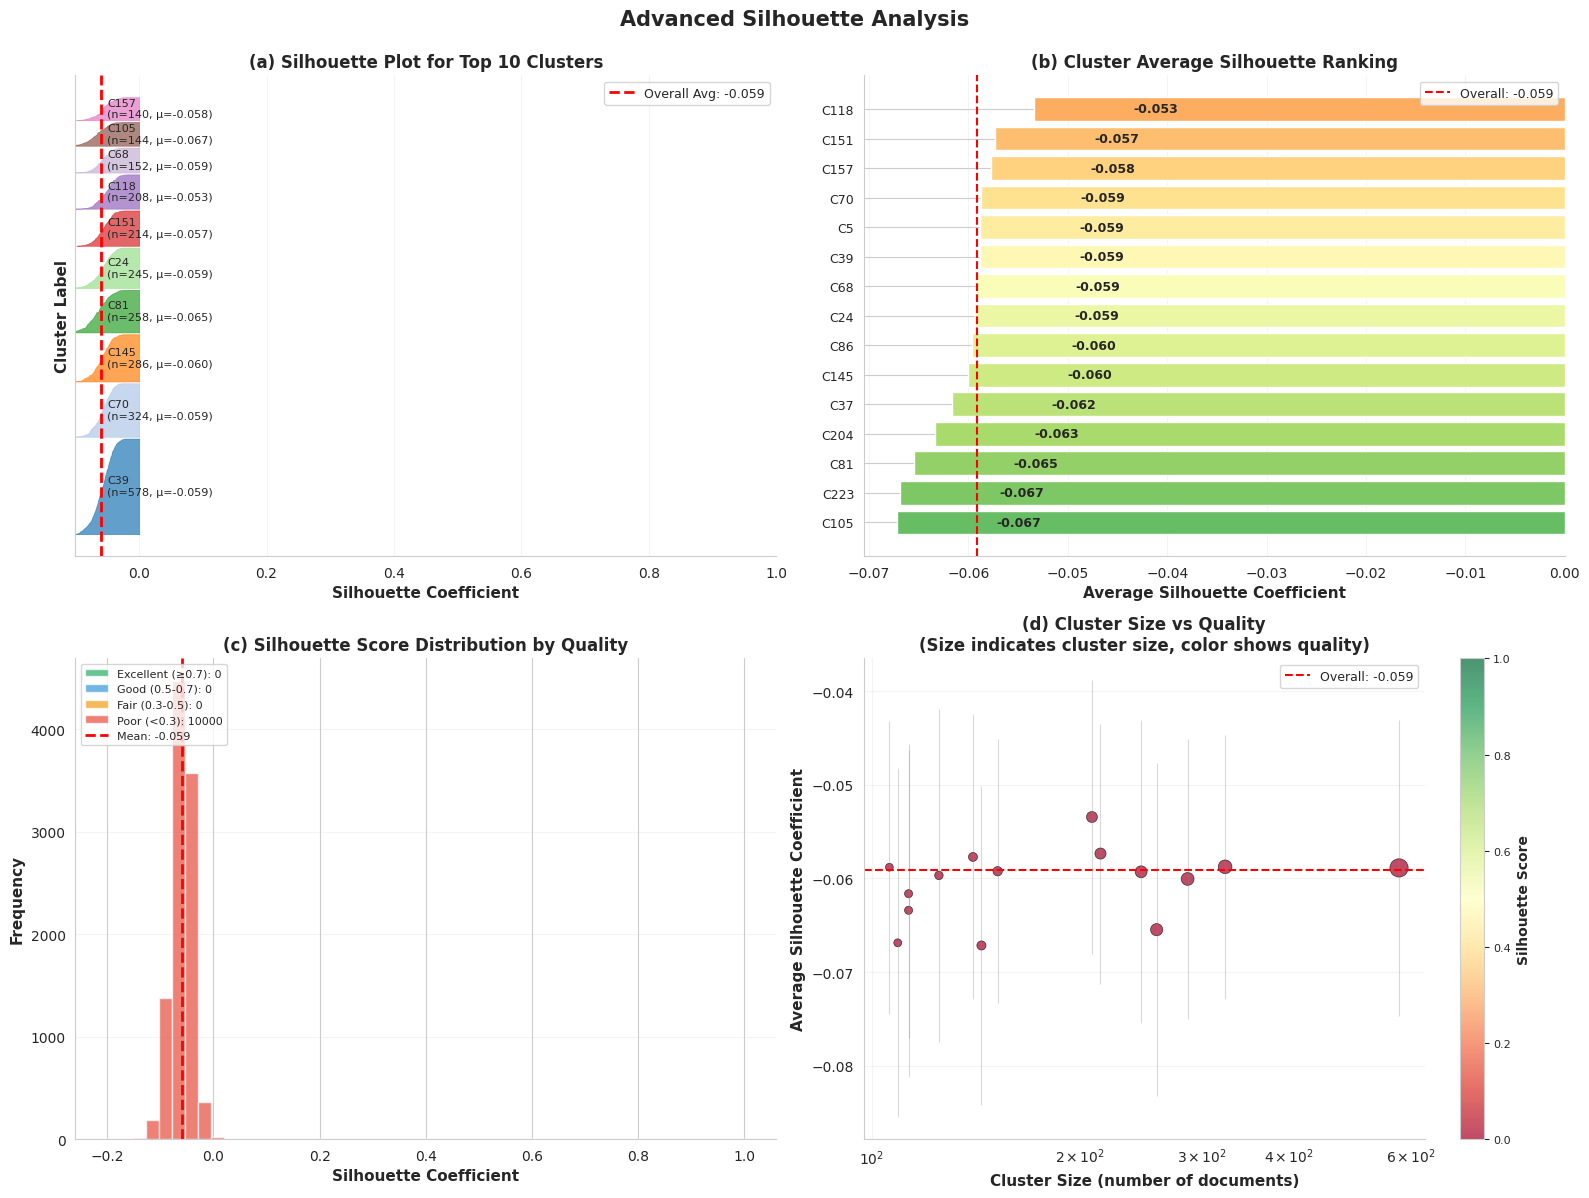

In [7]:
print("\n[5] Creating advanced silhouette analysis...")


def plot_advanced_silhouette_analysis(embeddings: np.ndarray, labels: np.ndarray, 
                                      top_clusters: int = 15):
    print("[i] Creating advanced silhouette analysis...")
    
    clustered_mask = labels != -1
    X_clustered = embeddings[clustered_mask]
    labels_clustered = labels[clustered_mask]
    
    sample_size = min(10000, len(X_clustered))
    if len(X_clustered) > sample_size:
        indices = np.random.choice(len(X_clustered), size=sample_size, replace=False)
        X_sample = X_clustered[indices]
        labels_sample = labels_clustered[indices]
    else:
        X_sample = X_clustered
        labels_sample = labels_clustered
    
    from sklearn.metrics import silhouette_samples, silhouette_score
    
    unique_labels = np.unique(labels_sample)
    silhouette_scores = silhouette_samples(X_sample, labels_sample, metric='euclidean')
    avg_silhouette = silhouette_score(X_sample, labels_sample, metric='euclidean')
    
    label_counts = Counter(labels_sample)
    top_labels = [label for label, _ in label_counts.most_common(top_clusters)]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Advanced Silhouette Analysis', fontsize=15, fontweight='bold', y=0.995)
    
    ax1 = axes[0, 0]
    y_lower = 10
    
    for i, label in enumerate(top_labels[:10]):  
        mask = labels_sample == label
        cluster_silhouette = silhouette_scores[mask]
        cluster_silhouette.sort()
        
        size = mask.sum()
        y_upper = y_lower + size
        
        color = plt.cm.tab20(i / len(top_labels))
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette,
                            facecolor=color, edgecolor=color, alpha=0.7, linewidth=0.5)
        
        avg_sil = cluster_silhouette.mean()
        ax1.text(-0.05, y_lower + 0.5 * size, f'C{label}\n(n={size}, μ={avg_sil:.3f})',
                fontsize=8, va='center')
        
        y_lower = y_upper + 10
    
    ax1.axvline(x=avg_silhouette, color="red", linestyle="--", 
                linewidth=2, label=f'Overall Avg: {avg_silhouette:.3f}')
    ax1.set_xlabel('Silhouette Coefficient', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Cluster Label', fontsize=11, fontweight='bold')
    ax1.set_title(f'(a) Silhouette Plot for Top {min(10, len(top_labels))} Clusters', 
                    fontsize=12, fontweight='bold')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.2, axis='x')
    
    ax2 = axes[0, 1]
    cluster_avg_sil = {}
    for label in top_labels:
        mask = labels_sample == label
        cluster_avg_sil[label] = silhouette_scores[mask].mean()
    
    sorted_clusters = sorted(cluster_avg_sil.items(), key=lambda x: x[1], reverse=True)
    cluster_ids = [f'C{label}' for label, _ in sorted_clusters]
    avg_sils = [sil for _, sil in sorted_clusters]
    
    bars = ax2.barh(range(len(cluster_ids)), avg_sils, 
                    color=plt.cm.RdYlGn(np.linspace(0.3, 0.8, len(cluster_ids))),
                    edgecolor='white', linewidth=1)
    
    for i, (bar, sil) in enumerate(zip(bars, avg_sils)):
        ax2.text(sil + 0.01, bar.get_y() + bar.get_height()/2,
                f'{sil:.3f}', va='center', fontsize=9, fontweight='bold')
    
    ax2.set_yticks(range(len(cluster_ids)))
    ax2.set_yticklabels(cluster_ids, fontsize=9)
    ax2.set_xlabel('Average Silhouette Coefficient', fontsize=11, fontweight='bold')
    ax2.set_title('(b) Cluster Average Silhouette Ranking', fontsize=12, fontweight='bold')
    ax2.axvline(x=avg_silhouette, color='red', linestyle='--', 
                linewidth=1.5, label=f'Overall: {avg_silhouette:.3f}')
    ax2.legend(fontsize=9)
    ax2.invert_yaxis()
    ax2.grid(True, alpha=0.2, axis='x')
    
    ax3 = axes[1, 0]
    
    excellent = silhouette_scores >= 0.7
    good = (silhouette_scores >= 0.5) & (silhouette_scores < 0.7)
    fair = (silhouette_scores >= 0.3) & (silhouette_scores < 0.5)
    poor = silhouette_scores < 0.3
    
    bins = np.linspace(-0.2, 1.0, 50)
    ax3.hist(silhouette_scores[excellent], bins=bins, alpha=0.7, 
            color=COLORS['success'], label=f'Excellent (≥0.7): {excellent.sum()}')
    ax3.hist(silhouette_scores[good], bins=bins, alpha=0.7, 
            color=COLORS['info'], label=f'Good (0.5-0.7): {good.sum()}')
    ax3.hist(silhouette_scores[fair], bins=bins, alpha=0.7, 
            color=COLORS['warning'], label=f'Fair (0.3-0.5): {fair.sum()}')
    ax3.hist(silhouette_scores[poor], bins=bins, alpha=0.7, 
            color=COLORS['accent'], label=f'Poor (<0.3): {poor.sum()}')
    
    ax3.axvline(x=avg_silhouette, color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {avg_silhouette:.3f}')
    ax3.set_xlabel('Silhouette Coefficient', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax3.set_title('(c) Silhouette Score Distribution by Quality', 
                    fontsize=12, fontweight='bold')
    ax3.legend(fontsize=8, loc='upper left')
    ax3.grid(True, alpha=0.2, axis='y')
    
    ax4 = axes[1, 1]
    
    cluster_size_sil = {}
    for label in top_labels:
        mask = labels_sample == label
        cluster_size_sil[label] = {
            'size': mask.sum(),
            'silhouette': silhouette_scores[mask].mean(),
            'std': silhouette_scores[mask].std()
        }
    
    sizes = [v['size'] for v in cluster_size_sil.values()]
    sils = [v['silhouette'] for v in cluster_size_sil.values()]
    stds = [v['std'] for v in cluster_size_sil.values()]
    
    scatter = ax4.scatter(sizes, sils, s=[s*0.3 for s in sizes], 
                            c=sils, cmap='RdYlGn', 
                            alpha=0.7, edgecolors='black', linewidth=0.5,
                            vmin=0, vmax=1)
    
    for i, (size, sil, std) in enumerate(zip(sizes, sils, stds)):
        ax4.errorbar(size, sil, yerr=std, fmt='none', 
                    color='gray', alpha=0.3, linewidth=0.8)
    
    ax4.set_xlabel('Cluster Size (number of documents)', 
                    fontsize=11, fontweight='bold')
    ax4.set_ylabel('Average Silhouette Coefficient', 
                    fontsize=11, fontweight='bold')
    ax4.set_title('(d) Cluster Size vs Quality\n(Size indicates cluster size, color shows quality)', 
                    fontsize=12, fontweight='bold')
    ax4.set_xscale('log')
    ax4.axhline(y=avg_silhouette, color='red', linestyle='--', 
                linewidth=1.5, label=f'Overall: {avg_silhouette:.3f}')
    
    cbar = plt.colorbar(scatter, ax=ax4)
    cbar.set_label('Silhouette Score', fontsize=10, fontweight='bold')
    cbar.ax.tick_params(labelsize=8)
    
    ax4.legend(fontsize=9)
    ax4.grid(True, alpha=0.2)
    
    plt.tight_layout()
    plt.savefig(VIZ_OUT_DIR / "advanced_silhouette_analysis.png", 
                dpi=300, bbox_inches='tight', facecolor='white')
    print(f"[i] Saved: {VIZ_OUT_DIR / 'advanced_silhouette_analysis.png'}")
    plt.show()


plot_advanced_silhouette_analysis(embeddings, labels)




[6] Creating parameter sensitivity analysis...
[i] Creating parameter sensitivity analysis...
[i] Saved: /work3/s242644/ds/PaperTrail/data/sbert_hdbscan_7w/visualizations/paper_quality/parameter_sensitivity_analysis.png


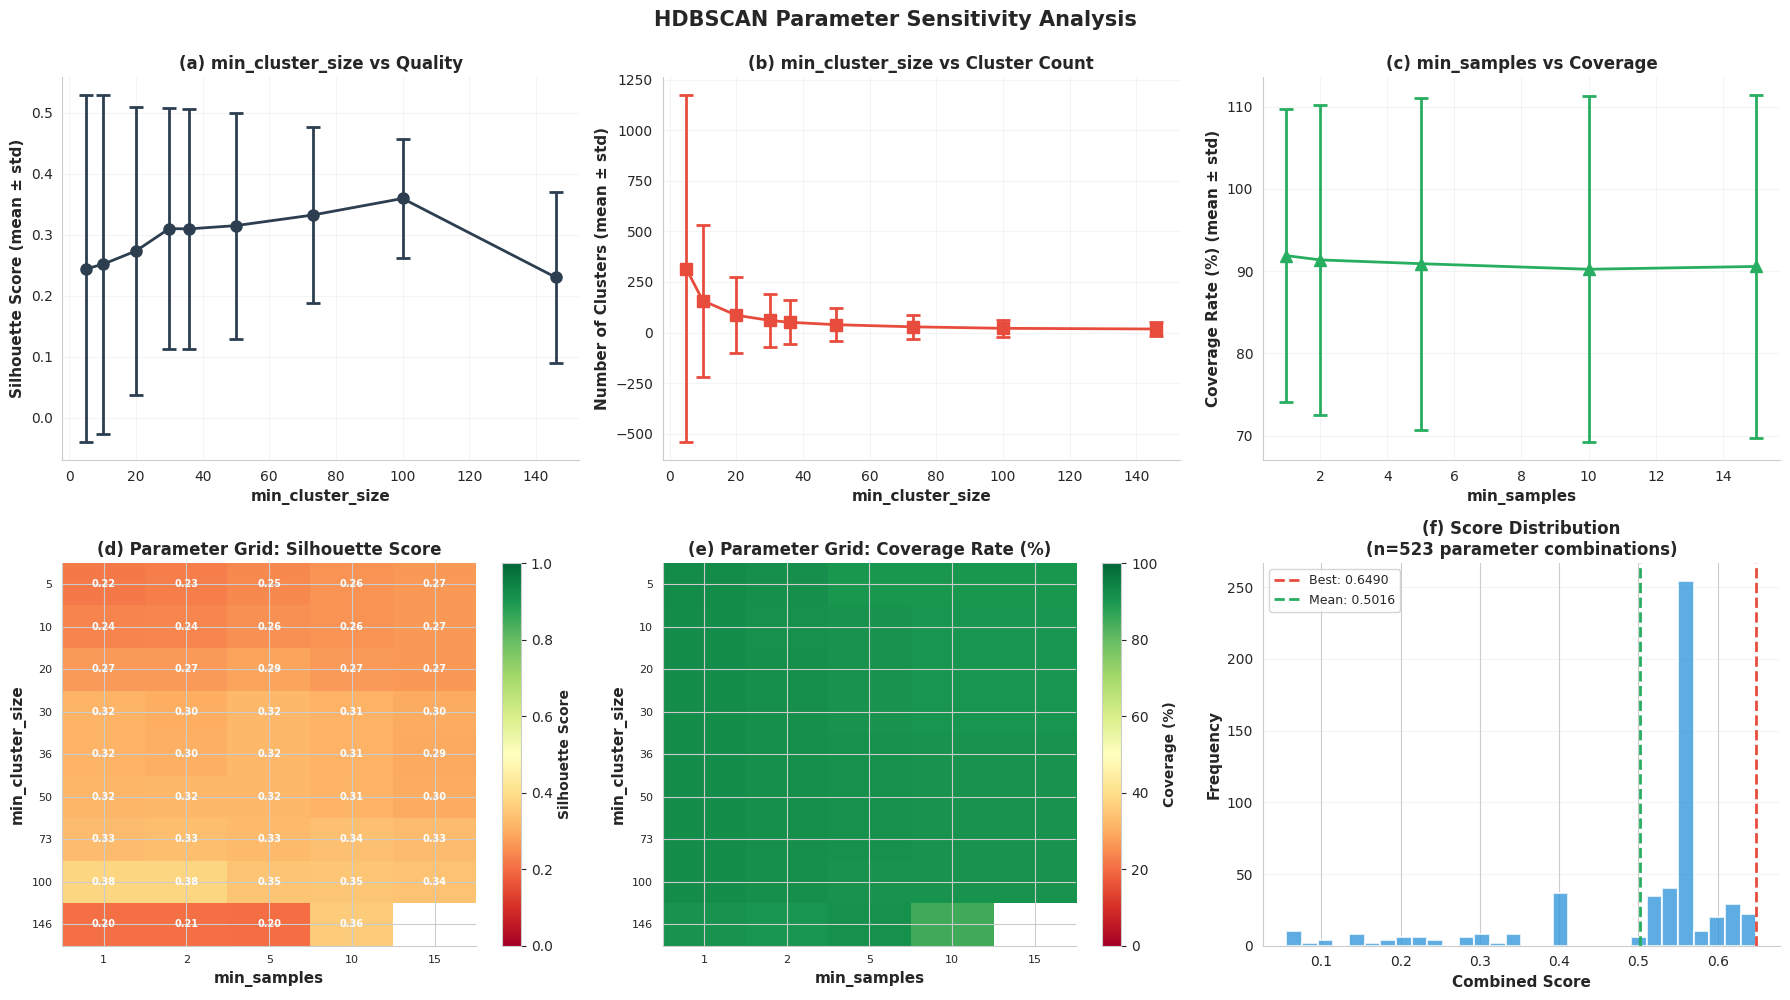

In [8]:
print("\n[6] Creating parameter sensitivity analysis...")

def plot_parameter_sensitivity(csv_log_path: Optional[Path] = None):
    print("[i] Creating parameter sensitivity analysis...")
    
    if csv_log_path is None:
        log_files = sorted(OUT_DIR.glob("hdbscan_search_log_*.csv"))
        if not log_files:
            print("[warn] No parameter search log found, skipping sensitivity analysis")
            return
        csv_log_path = log_files[-1]  
    
    if csv_log_path.exists():
        df = pd.read_csv(csv_log_path)
    else:
        print(f"[warn] Log file not found: {csv_log_path}")
        return
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('HDBSCAN Parameter Sensitivity Analysis', 
                    fontsize=15, fontweight='bold', y=0.995)
    
    ax1 = axes[0, 0]
    grouped = df.groupby('min_cluster_size')['silhouette'].agg(['mean', 'std', 'count'])
    ax1.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'], 
                fmt='o-', color=COLORS['primary'], linewidth=2, 
                markersize=8, capsize=5, capthick=2)
    ax1.set_xlabel('min_cluster_size', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Silhouette Score (mean ± std)', fontsize=11, fontweight='bold')
    ax1.set_title('(a) min_cluster_size vs Quality', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.2)
    
    ax2 = axes[0, 1]
    grouped_k = df.groupby('min_cluster_size')['num_clusters'].agg(['mean', 'std'])
    ax2.errorbar(grouped_k.index, grouped_k['mean'], yerr=grouped_k['std'],
                fmt='s-', color=COLORS['accent'], linewidth=2,
                markersize=8, capsize=5, capthick=2)
    ax2.set_xlabel('min_cluster_size', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Number of Clusters (mean ± std)', fontsize=11, fontweight='bold')
    ax2.set_title('(b) min_cluster_size vs Cluster Count', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.2)
    
    ax3 = axes[0, 2]
    if 'min_samples' in df.columns:
        grouped_cov = df.groupby('min_samples')['clustered_percentage'].agg(['mean', 'std'])
        ax3.errorbar(grouped_cov.index, grouped_cov['mean'] * 100, 
                    yerr=grouped_cov['std'] * 100,
                    fmt='^-', color=COLORS['success'], linewidth=2,
                    markersize=8, capsize=5, capthick=2)
        ax3.set_xlabel('min_samples', fontsize=11, fontweight='bold')
        ax3.set_ylabel('Coverage Rate (%) (mean ± std)', fontsize=11, fontweight='bold')
        ax3.set_title('(c) min_samples vs Coverage', fontsize=12, fontweight='bold')
        ax3.grid(True, alpha=0.2)
    
    ax4 = axes[1, 0]
    if 'min_cluster_size' in df.columns and 'min_samples' in df.columns:
        pivot_sil = df.pivot_table(values='silhouette', 
                                    index='min_cluster_size', 
                                    columns='min_samples', 
                                    aggfunc='mean')
        im = ax4.imshow(pivot_sil.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
        ax4.set_xticks(np.arange(len(pivot_sil.columns)))
        ax4.set_yticks(np.arange(len(pivot_sil.index)))
        ax4.set_xticklabels(pivot_sil.columns, fontsize=8)
        ax4.set_yticklabels(pivot_sil.index, fontsize=8)
        ax4.set_xlabel('min_samples', fontsize=11, fontweight='bold')
        ax4.set_ylabel('min_cluster_size', fontsize=11, fontweight='bold')
        ax4.set_title('(d) Parameter Grid: Silhouette Score', 
                        fontsize=12, fontweight='bold')
        cbar = plt.colorbar(im, ax=ax4)
        cbar.set_label('Silhouette Score', fontsize=10, fontweight='bold')
        
        for i in range(len(pivot_sil.index)):
            for j in range(len(pivot_sil.columns)):
                val = pivot_sil.values[i, j]
                if not np.isnan(val):
                    text_color = 'white' if val < 0.5 else 'black'
                    ax4.text(j, i, f'{val:.2f}', ha='center', va='center',
                            color=text_color, fontsize=7, fontweight='bold')
    
    ax5 = axes[1, 1]
    if 'min_cluster_size' in df.columns and 'min_samples' in df.columns:
        pivot_cov = df.pivot_table(values='clustered_percentage', 
                                    index='min_cluster_size', 
                                    columns='min_samples', 
                                    aggfunc='mean')
        im = ax5.imshow(pivot_cov.values * 100, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)
        ax5.set_xticks(np.arange(len(pivot_cov.columns)))
        ax5.set_yticks(np.arange(len(pivot_cov.index)))
        ax5.set_xticklabels(pivot_cov.columns, fontsize=8)
        ax5.set_yticklabels(pivot_cov.index, fontsize=8)
        ax5.set_xlabel('min_samples', fontsize=11, fontweight='bold')
        ax5.set_ylabel('min_cluster_size', fontsize=11, fontweight='bold')
        ax5.set_title('(e) Parameter Grid: Coverage Rate (%)', 
                        fontsize=12, fontweight='bold')
        cbar = plt.colorbar(im, ax=ax5)
        cbar.set_label('Coverage (%)', fontsize=10, fontweight='bold')
    
    ax6 = axes[1, 2]
    if 'score' in df.columns:
        ax6.hist(df['score'], bins=30, color=COLORS['secondary'], 
                edgecolor='white', linewidth=1.5, alpha=0.8)
        ax6.axvline(x=df['score'].max(), color=COLORS['accent'], 
                    linestyle='--', linewidth=2, 
                    label=f'Best: {df["score"].max():.4f}')
        ax6.axvline(x=df['score'].mean(), color=COLORS['success'], 
                    linestyle='--', linewidth=2, 
                    label=f'Mean: {df["score"].mean():.4f}')
        ax6.set_xlabel('Combined Score', fontsize=11, fontweight='bold')
        ax6.set_ylabel('Frequency', fontsize=11, fontweight='bold')
        ax6.set_title(f'(f) Score Distribution\n(n={len(df)} parameter combinations)', 
                        fontsize=12, fontweight='bold')
        ax6.legend(fontsize=9)
        ax6.grid(True, alpha=0.2, axis='y')
    
    plt.tight_layout()
    plt.savefig(VIZ_OUT_DIR / "parameter_sensitivity_analysis.png", 
                dpi=300, bbox_inches='tight', facecolor='white')
    print(f"[i] Saved: {VIZ_OUT_DIR / 'parameter_sensitivity_analysis.png'}")
    plt.show()

plot_parameter_sensitivity()




[7] Creating detailed cluster topics...
[i] Creating detailed cluster topics visualization...
[i] Saved: /work3/s242644/ds/PaperTrail/data/sbert_hdbscan_7w/visualizations/paper_quality/detailed_cluster_topics.png


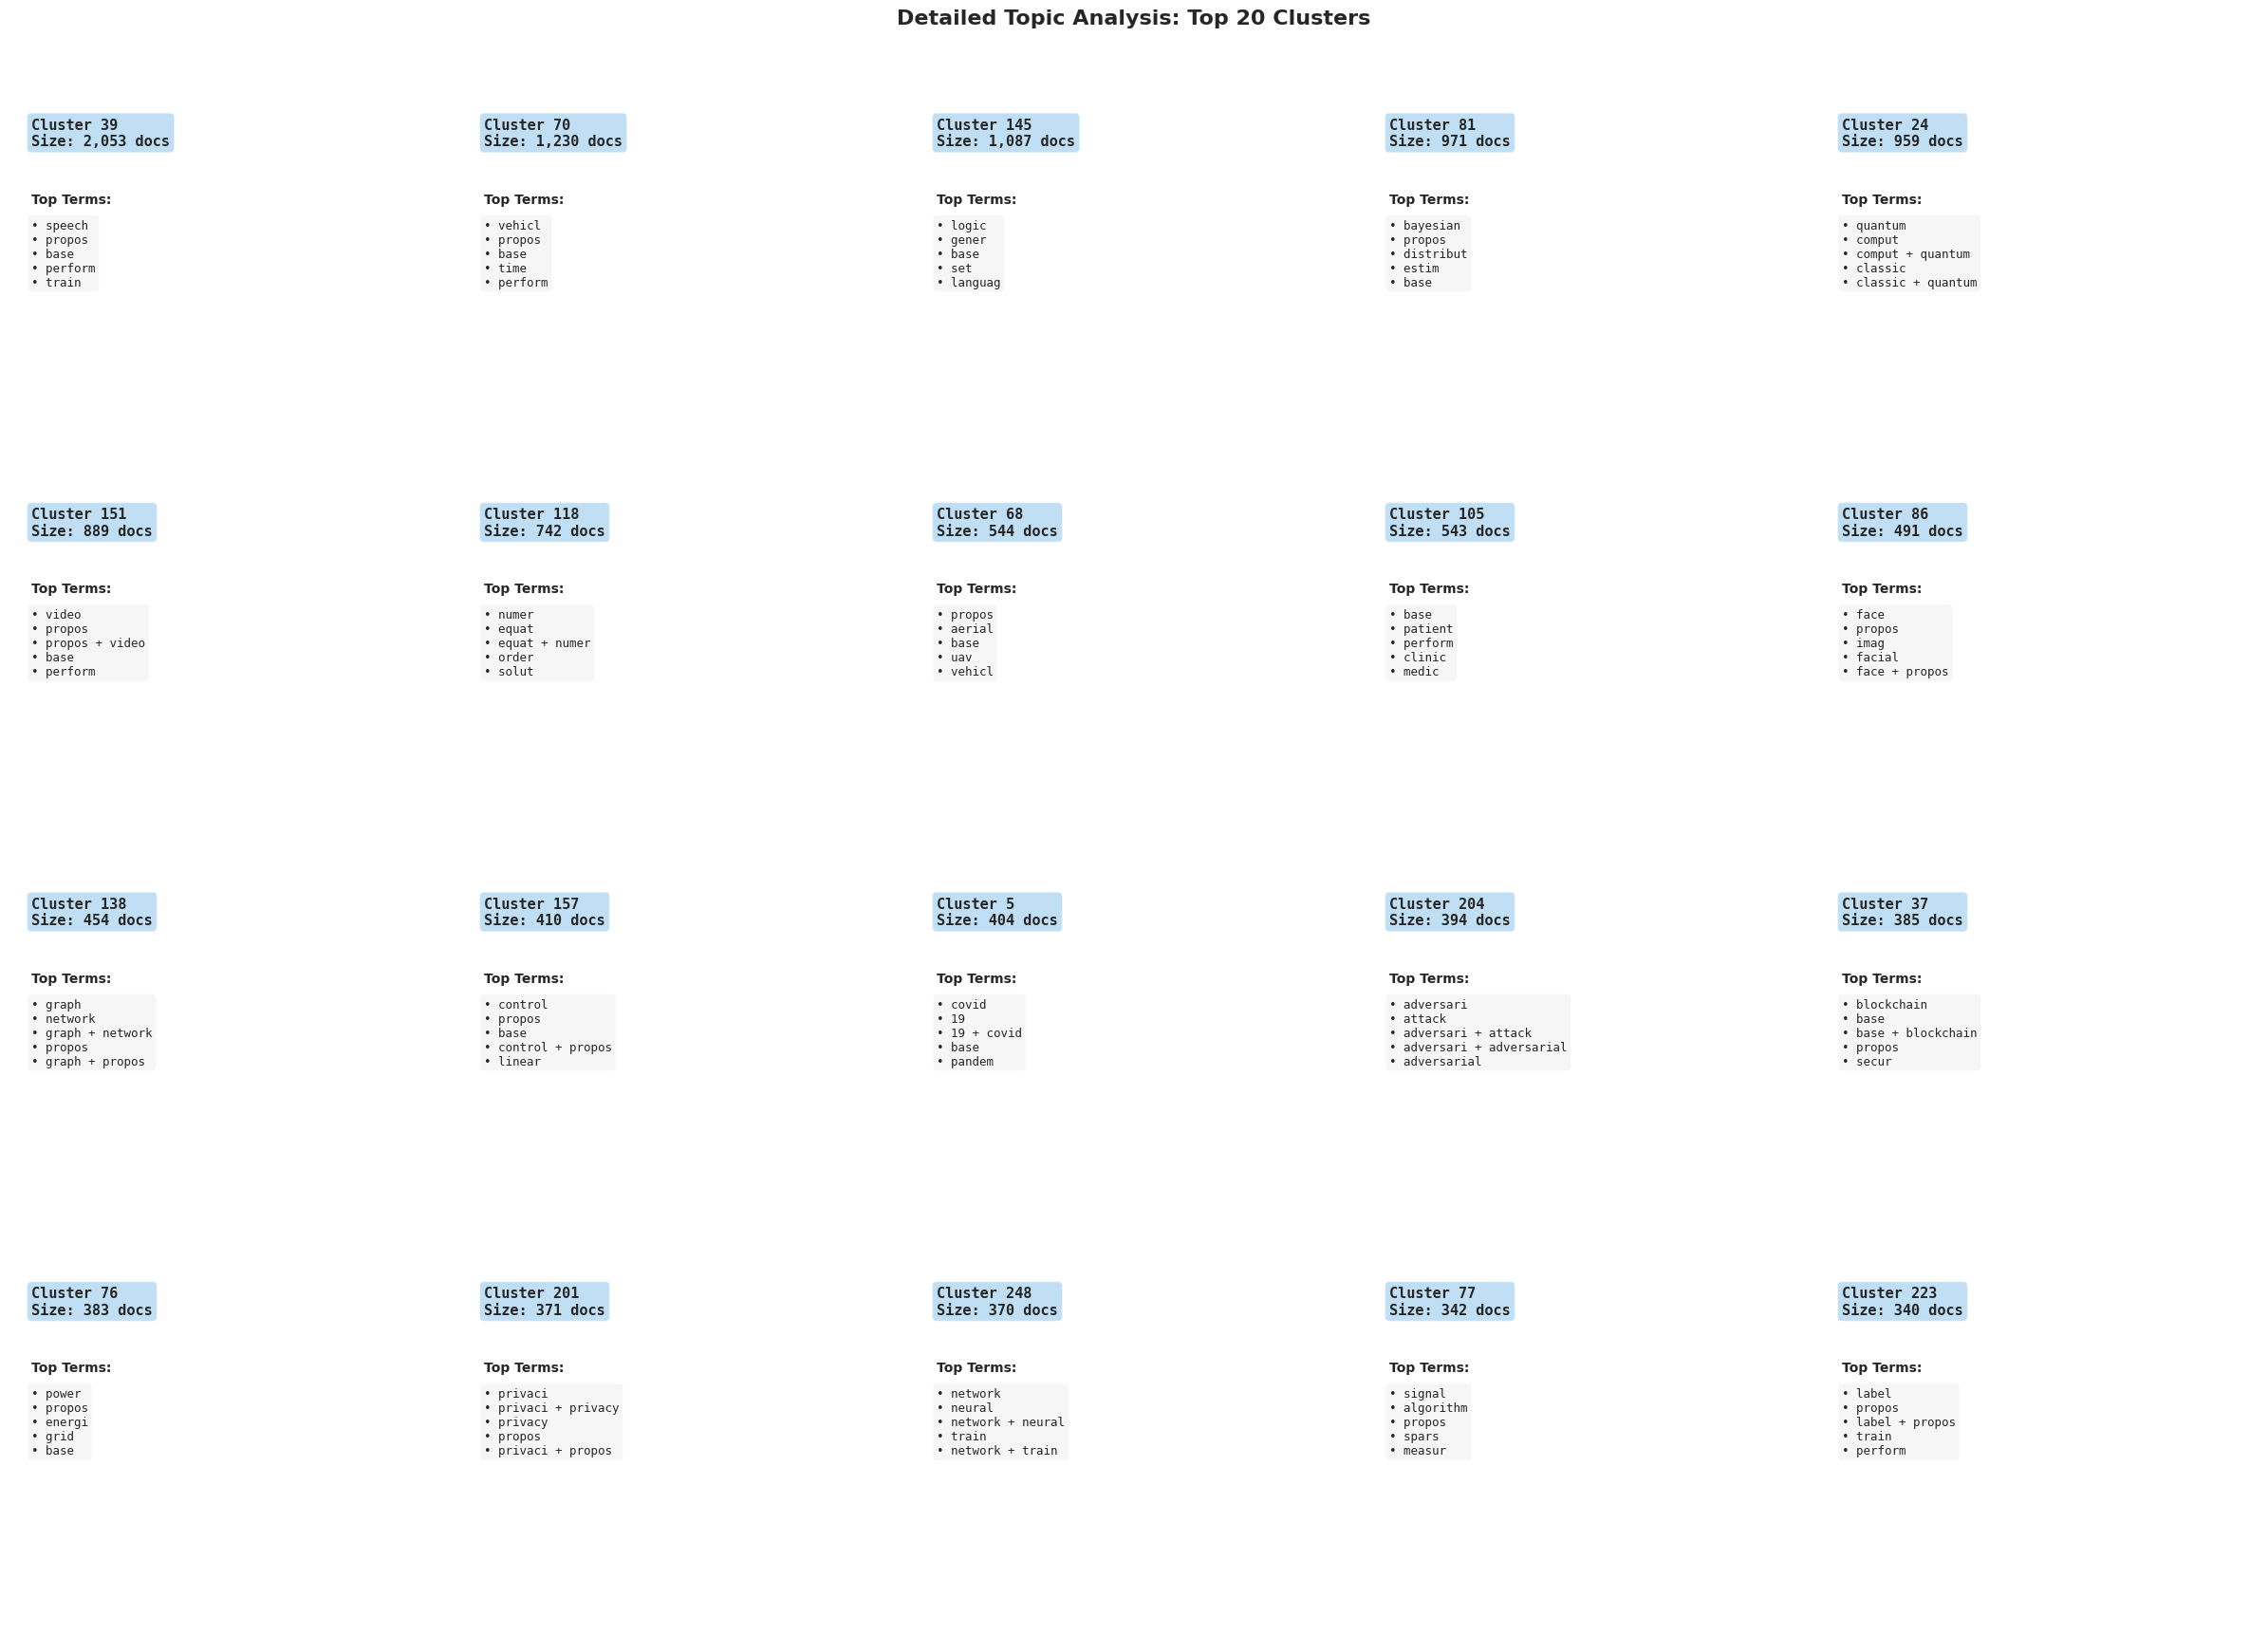

In [ ]:
print("\n[7] Creating detailed cluster topics...")

def plot_cluster_topics_detailed(cluster_top_terms: Dict, labels: np.ndarray, 
                                 doc_titles: np.ndarray, top_n: int = 20):
    print("[i] Creating detailed cluster topics visualization...")
    
    unique_labels, counts = np.unique(labels[labels != -1], return_counts=True)
    label_to_count = dict(zip(unique_labels, counts))
    
    sorted_clusters = sorted(label_to_count.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    fig, axes = plt.subplots(4, 5, figsize=(24, 18))
    fig.suptitle(f'Detailed Topic Analysis: Top {top_n} Clusters', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    axes = axes.flatten()
     
    for idx, (cluster_id, size) in enumerate(sorted_clusters):
        ax = axes[idx]
        cluster_id_str = str(cluster_id)
        
        if cluster_id_str in cluster_top_terms:
            terms = cluster_top_terms[cluster_id_str][:10]  
            terms_text = '\n'.join([f'• {term[:25]}' for term in terms])
        else:
            terms_text = "No terms extracted"
        
        ax.text(0.05, 0.95, f'Cluster {cluster_id}\nSize: {size:,} docs', 
               transform=ax.transAxes, fontsize=11, fontweight='bold',
               verticalalignment='top', family='monospace',
               bbox=dict(boxstyle='round', facecolor=COLORS.get('secondary', '#add8e6'), alpha=0.3))
        
        ax.text(0.05, 0.75, 'Top Terms:', transform=ax.transAxes, 
               fontsize=10, fontweight='bold', verticalalignment='top')
        
        ax.text(0.05, 0.68, terms_text, transform=ax.transAxes, 
               fontsize=9, verticalalignment='top', family='monospace',
               bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.2))
               
        
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.axis('off')
    
    for idx in range(len(sorted_clusters), len(axes)):
        axes[idx].axis('off')
        
    plt.tight_layout()
    save_path = VIZ_OUT_DIR / "detailed_cluster_topics.png"
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"[i] Saved: {save_path}")
    plt.show()


plot_cluster_topics_detailed(cluster_top_terms, labels, doc_titles)

